In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
 
# your openai key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
 
# Your host, defaults to https://cloud.langfuse.com
# For US data region, set to "https://us.cloud.langfuse.com"
# os.environ["LANGFUSE_HOST"] = "http://localhost:3000"


TypeError: str expected, not NoneType

In [4]:
import fitz  # PyMuPDF
from langdetect import detect
import re

def clean_text(text):
    # Replace multiple whitespace with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    return text

def extract_and_clean_english_text(pdf_path, max_page=66):
    """
    Extracts and cleans English text from a PDF up to a specified page.
    
    Args:
    pdf_path (str): The path to the PDF file.
    max_page (int): The maximum number of pages to process.

    Returns:
    str: The cleaned and concatenated English text extracted from the PDF.
    """
    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    # Initialize a list to hold all English text
    english_text = []

    # Loop through each page in the PDF until the specified max_page
    for page_num in range(min(len(pdf_document), max_page)):
        page = pdf_document.load_page(page_num)
        
        # Extract text from the page
        text = page.get_text("text")
        
        # Split text into sentences/lines
        lines = re.split(r'\n', text)
        
        # Detect language and filter for English
        for line in lines:
            try:
                if detect(line) == 'en':
                    cleaned_line = clean_text(line)
                    if cleaned_line:  # Add only non-empty cleaned lines
                        english_text.append(cleaned_line)
            except:
                continue  # Skip lines where language detection fails

    return " ".join(english_text)

# Use the function
pdf_path = "washer.pdf"
english_text = extract_and_clean_english_text(pdf_path)
print(english_text)

Untitled-5 1 English Safety information What you need to know about the safety instructions Important safety symbols Critical installation warnings Critical usage warnings Critical cleaning warnings Whats included Step-by-step installation Before you start Initial settings Operations Simple steps to start Cycle overview Smart Check Emergency drain Recovery from freezing Care against an extended time of disuse Untitled-5 2 English 3 Troubleshooting Checkpoints Information codes Specifications Protecting the environment Specification sheet Information of main washing cycles Untitled-5 3 English Safety information Congratulations on your new Samsung washing machine. This manual contains important information on the installation, use and care of your appliance. Please take some time to read this manual to take full advantage of your washing machines many benefits and features. What you need to know about the safety instructions Please read this manual thoroughly to ensure that you know how

In [67]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma 
from langchain_openai import OpenAIEmbeddings



# Set embeddings
embd = OpenAIEmbeddings()

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=500
)

def split_text_into_chunks(text, chunk_size=2000, chunk_overlap=350):
    # Initialize the text splitter
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    
    # Split the text into chunks
    text_chunks = text_splitter.split_text(text)
    return text_chunks

# Use the functions
pdf_path = "washer.pdf"
cleaned_english_text = extract_and_clean_english_text(pdf_path)
text_chunks = split_text_into_chunks(cleaned_english_text)






# Add to vectorstore
vectorstore = Chroma.from_texts(
  texts=text_chunks,
  collection_name="rag-chroma",
  embedding=embd
)

retriever = vectorstore.as_retriever()

In [66]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)


from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)


In [58]:
# Define the original question
question = "what are the procedure of installation of the washer machine ?"

# Use the generate_queries chain
alternative_queries = generate_queries.invoke({"question": question})

print(alternative_queries)


['1. How can I properly install a washing machine?', '2. What steps are involved in setting up a washer machine?', '3. What is the process for installing a washing machine?', '4. Can you outline the steps for installing a washer machine?', '5. What are the necessary procedures for setting up a washing machine?']


In [65]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]
# Retrieve
question = "what are the componments of the washer machine?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union


docs = retrieval_chain.invoke({"question":question})
len(docs)




8

In [ ]:
print(type(retrieval_chain))  # Should be a LangChain Chain or RunnableSequence

print(type(docs))  # Should be a list of documents


<class 'langchain_core.runnables.base.RunnableSequence'>
<class 'list'>


In [ ]:
! pip install langfuse

In [28]:
from langfuse.callback import CallbackHandler
langfuse_handler=CallbackHandler()

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


In [41]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter
import json
# Define the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant, Answer the question based only on the following context :{context}"
            "Answer the question based on the above question: {question}"
            "Provide a detailed answer."
            "Don't justify your answers."
            "Don't give information not mentioned in the CONTEXT INFORMATION."
            "Do not say ""according to the context" "or ""mentioned in the context" "or similar."
            "if you don't know the answer, don't halucinate.Just say:'I can't answer this question  since it is not mentioned in the context."),
    """),
    ("human", "{question}"),
])

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

# Define the chain
final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

# Define your question and retrieval chain
question = "what are the procedure of installation of the washer machine ?"

# Invoke the chain
response = final_rag_chain.invoke({"question": question}, config={"callbacks": [langfuse_handler]})
print(response)



The procedure for installing the washing machine includes the following steps:

1. Select a location: Choose a solid, level surface without carpeting or flooring that may obstruct ventilation. Ensure the area is away from direct sunlight, has adequate room for ventilation and wiring, and maintains an ambient temperature higher than the freezing point.

2. Remove the shipping bolts: Unpack the product package and remove all shipping bolts using the supplied spanner. Fill the holes with the supplied plastic hose guide and secure it to the wall.

3. Adjust the levelling feet: Gently slide the washing machine into the levelling feet and manually adjust them to level the machine. Tighten the nuts using the spanner once levelling is complete.

4. Connect the water hose: Connect the water hose to the water tap and the inlet valve on the back of the washing machine. Ensure there are no leaks around the connection areas.

5. Connect the drain hose: Connect the drain hose through the hose clip t

In [43]:
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant, Answer the question based only on the following context :{context}"
            "Answer the question based on the above question: {question}"
            "Provide a detailed answer."
            "Don't justify your answers."
            "Don't give information not mentioned in the CONTEXT INFORMATION."
            "Do not say ""according to the context" "or ""mentioned in the context" "or similar."
            "if you don't know the answer, don't halucinate.Just say:'I can't answer this question  since it is not mentioned in the context."),
    """),
    ("human", "{question}"),
])

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)

# Define the chain
final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

questions=[]

def generate_answers(questions):
    answers = []
    for question in questions:    
        response = final_rag_chain.invoke({"question": question}, config={"callbacks": [langfuse_handler]})
        answers.append(response)
    return answers

In [45]:
print(type(retrieval_chain))

<class 'langchain_core.runnables.base.RunnableSequence'>


In [70]:
import json

# Load JSON data from file
with open('data.json', 'r') as file:
    data = json.load(file)

QA = data['questions']
questions= []

# Iterate through the list and print each question and answer
for item in QA:
    for key, value in item.items():
        if key!="answer" :
           questions.append(value)
        
# Print the results
print(questions)
print(len(questions))

['What should you do to ensure you know how to safely and efficiently operate your new appliance?', 'Where should you store the manual for future reference?', 'For what purpose should you use the appliance according to the manual?', 'Do the Warnings and Important Safety Instructions cover all possible conditions and situations?', 'What is your responsibility when installing, maintaining, and operating the washing machine?', 'Why might the characteristics of your washing machine differ slightly from those described in the manual?', 'What should you do if you have any questions or concerns?', 'What does the WARNING symbol indicate in the user manual?', 'What does the CAUTION symbol mean in the user manual?', 'What does the NOTE symbol signify in the user manual?', 'what should we do if the supply cord is damaged ?', 'how to reduce the risk of fire, electric shock, or injury to persons when using your appliance', ' What is the age requirement for children to use the appliance in Europe? '

In [153]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Define the evaluation prompt template
hallucination_prompt = ChatPromptTemplate.from_messages([
    ("system", """Evaluate the degree of hallucination in the generation on a continuous scale from 0 to 1.
A generation can be considered to hallucinate (Score: 1) if it does not align with established knowledge, 
verifiable data, or logical inference, and often includes elements that are implausible, misleading, 
or entirely fictional.

Example 1 (High Degree of Hallucination):
Query: What are some common maintenance tasks for a washing machine?
Generation: To maintain your washing machine, you should regularly water it with a special machine conditioner,
clean the inside with lemon juice to prevent rust, 
and replace the entire drum every six months to ensure optimal performance.

Score: 1 

Explanation:
- Watering with a special machine conditioner: This is not a standard maintenance practice for washing machines.
- Cleaning the inside with lemon juice: While lemon juice is useful for cleaning some surfaces, it's not a recommended method for maintaining a washing machine.
- Replacing the drum every six months: Replacing the drum this frequently is unnecessary and not a standard practice.

This hallucinated output includes several inaccuracies or fabricated recommendations 
that are not part of normal washing machine maintenance procedures.


Example 2 (Low Degree of Hallucination):
Query: What precautions should you take when using a washing machine?
Generation: Always ensure that the washing machine is placed on a flat surface, and avoid overloading it to prevent mechanical issues.

Score: 0

Explanation:
- Placing on a flat surface: This is standard advice for ensuring proper operation of the washing machine.
- Avoiding overloading: This is a common and sensible recommendation to prevent mechanical problems.

This response aligns well with established knowledge and standard practices, and there are no significant inaccuracies or fabricated information.

Input:
Query: {query}
Generation: {generation}

Think step by step, and print only the value of the score.

""")
])

# Initialize the language model
llm = ChatOpenAI(temperature=0)



responses = generate_answers(questions)
# Initialize output list
hallucination_scores = []

# Evaluate hallucination score for each question-answer pair
for question, response in zip(questions, responses):
    # Format the prompt with the question and response
    formatted_prompt = hallucination_prompt.format_prompt(
        query=question,
        generation=response
    )
    
    # Get the LLM response
    model_response = llm(formatted_prompt)
    
    # Extract text from AIMessage object
    response_text = model_response.content if hasattr(model_response, 'content') else str(model_response)
    
    
    hallucination_scores.append(response_text)    

# Print or use the hallucination scores
print(hallucination_scores)


['0', '0', '0', 'Score: 0.5', '0.2', '0', '0.2', '0.', '0.', '0.2', '0.5', '1', '0.5', '0', '0.2', '1', '0', '1', '0.2', '0.2', '0.2', '0', '0', '0.2', '1', '0.', '0', '1', '0.2', '0.2', '0.2', '0', '0.5', '0.2', '0.2', '0.2', '0.2', '1', '0.2', '0.5', '1', '0', '0.2', '0', '0', '0.2', '0', '1', '0.2', '1', 'Score: 0.2', '0.2', '0', '0.2', '0.5', '0', '0.2', '0', '0.2', '0.2', '0', '0.2', '0', '0', '0.2', '0.2', '0.2', '1', '0.2', '0', '0.5', '0', '0.2', '0', '0.2', '0', '0.2', '0.2', '0.2', '0.2', '0.5', '0', '0', '0', '0.', '0.2', 'Score: 0', '1', '0', '0.5', 'Score: 0.2', 'Score: 0.2', '0', '0', '0.2', '0.2', '0', '0.2', '0', '0', '0', '0', '0.2', '0.2']


In [154]:
print(len(hallucination_scores))
def transform_list(input_list):
    transformed_list = []
    
    for item in input_list:
        if isinstance(item, str) and item.startswith('Score:'):
            # Extract the number after 'Score: '
            try:
                value = item.split(':')[1].strip()  # Get the part after ':'
                transformed_list.append(float(value))  # Convert to float and append
            except ValueError:
                # Handle unexpected formats gracefully (optional)
                print(f"Warning: Could not convert '{item}' to float.")
        else:
            # Directly append non-'Score:' items, convert to float if they are numeric strings
            try:
                transformed_list.append(float(item))
            except ValueError:
                print(f"Warning: '{item}' is not a valid number.")
    
    return transformed_list

# Example usage
input_list =hallucination_scores
hallucination_scores= transform_list(input_list)
print(hallucination_scores)


104
[0.0, 0.0, 0.0, 0.5, 0.2, 0.0, 0.2, 0.0, 0.0, 0.2, 0.5, 1.0, 0.5, 0.0, 0.2, 1.0, 0.0, 1.0, 0.2, 0.2, 0.2, 0.0, 0.0, 0.2, 1.0, 0.0, 0.0, 1.0, 0.2, 0.2, 0.2, 0.0, 0.5, 0.2, 0.2, 0.2, 0.2, 1.0, 0.2, 0.5, 1.0, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 1.0, 0.2, 1.0, 0.2, 0.2, 0.0, 0.2, 0.5, 0.0, 0.2, 0.0, 0.2, 0.2, 0.0, 0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 1.0, 0.2, 0.0, 0.5, 0.0, 0.2, 0.0, 0.2, 0.0, 0.2, 0.2, 0.2, 0.2, 0.5, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 1.0, 0.0, 0.5, 0.2, 0.2, 0.0, 0.0, 0.2, 0.2, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2]


In [ ]:
! pip install matplotlib

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


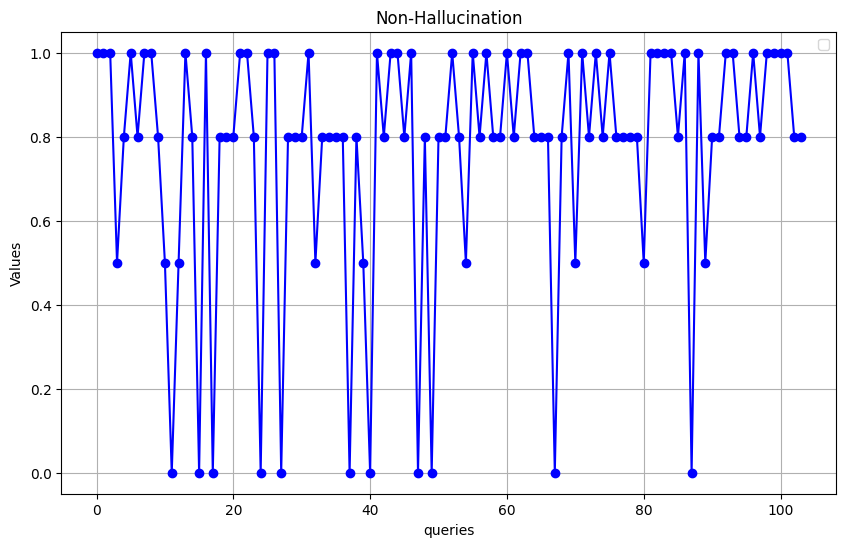

In [155]:
import matplotlib.pyplot as plt

# Liste des valeurs à tracer
values = hallucination_scores

# Création d'une liste pour les indices x (0, 1, 2, ..., len(values)-1)
x_values = range(len(values))

# Transformation des valeurs pour l'affichage
transformed_values = [1 - value for value in values]

# Création de la figure et des axes
plt.figure(figsize=(10, 6))

# Tracer la courbe avec les valeurs transformées
plt.plot(x_values, transformed_values, marker='o', linestyle='-', color='b')

# Ajouter des titres et labels
plt.title('Non-Hallucination')
plt.xlabel('queries')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()


In [156]:
avg=sum(hallucination_scores)/104
print(1-avg)

0.766346153846154


In [32]:
import json

# Load JSON data from file
with open('data.json', 'r') as file:
    data = json.load(file)

QA = data['questions']
ground_truths = []

# Iterate through the list and print each question and answer
for item in QA:
    for key, value in item.items():
        if key=="answer" :
            ground_truths.append(value)
        
# Print the results
print(ground_truths)
print(len(ground_truths))

['You should read the manual thoroughly to ensure that you know how to safely and efficiently operate the extensive features and functions of your new appliance.', 'You should store the manual in a safe location close to the appliance for future reference.', 'You should use the appliance only for its intended purpose as described in the instruction manual.', 'No, the Warnings and Important Safety Instructions in this manual do not cover all possible conditions and situations that may occur.', 'It is your responsibility to use common sense, caution, and care when installing, maintaining, and operating your washing machine.', 'The characteristics of your washing machine may differ slightly from those described in the manual because the following operating instructions cover various models.', 'If you have any questions or concerns, you should contact your nearest service centre or find help and information online at www.samsung.com', 'The WARNING symbol indicates hazards or unsafe practic

In [37]:
# Define the evaluation prompt template
correctness_prompt = ChatPromptTemplate.from_messages([
    ("system", """Evaluate the correctness of the generation on a continuous scale from 0 to 1, where:
- 1 means the generation is fully correct and includes all key facts from the ground truth.
- 0 means the generation is completely incorrect and does not align with the ground truth.

A generation is considered correct (Score: 1) if:
1. It includes all key facts from the ground truth.
2. Every fact presented in the generation is factually supported by the ground truth or common sense.

To assist in your evaluation, here are detailed examples:

Example 1:
Query: How often should the washing machine door seal be cleaned?
Generation: The washing machine door seal should be cleaned once a year.
Ground truth: The washing machine door seal should be cleaned every 1 to 2 months to prevent mold and mildew buildup.
Score: 0.1
Reasoning for Incorrectness:
- Inaccurate Information:
  The generation suggests cleaning once a year, which is significantly less frequent than the recommended 1 to 2 months. This can lead to mold and mildew buildup, causing maintenance issues.
- Failure to Align with Best Practices:
  The recommended interval for cleaning the door seal is every 1 to 2 months, not once a year. Proper maintenance requires more frequent cleaning to ensure efficiency and hygiene.

Example 2:
Query: How often should the washing machine lint filter be cleaned?
Generation: The lint filter should be cleaned after every load of laundry.
Ground truth: The lint filter should be cleaned after every load of laundry to prevent lint buildup and maintain optimal performance.
Score: 1
Reasoning for Correctness:
- Accurate Information:
  The generation correctly matches the ground truth by specifying that the lint filter should be cleaned after every load. This aligns with best practices for maintaining machine performance and safety.
- Alignment with Best Practices:
  Cleaning the lint filter after each load is the recommended practice for preventing lint buildup and ensuring the washing machine operates efficiently and safely. The response accurately reflects this best practice.

For each new input, use these criteria to determine the score:

Input:
Query: {query}
Generation: {generation}
Ground truth: {ground_truth}

Think step by step. Provide only the numerical score (between 0 and 1) based on the correctness of the generation.
""")
])


# Initialize the language model
llm = ChatOpenAI(temperature=0)

# Define a list of questions and get the answers


responses = generate_answers(questions)

# Initialize output list

correctness_scores=[]
print(len(ground_truths))
# Evaluate hallucination score for each question-answer pair

correctness_scores = []



for i, (question, ground_truth, response) in enumerate(zip(questions, ground_truths, responses)):
    try:
       
        
        # Format the prompt with the question and response
        formatted_prompt = correctness_prompt.format_prompt(
            query=question,
            ground_truth=ground_truth,
            generation=response
        )
        
       
        
        # Get the LLM response
        model_response = llm(formatted_prompt)
        
        # Extract text from AIMessage object or convert model response to string
        response_text = getattr(model_response, 'content', str(model_response))
        
        
        correctness_scores.append(response_text)
    
    except Exception as e:
        # Handle any exceptions that occur
        print(f"An error occurred at item {i + 1}: {e}")
        correctness_scores.append(f"Error: {e}")


print(correctness_scores)


104
['0.9', '1', '0.8', '0.9', '0.8', '0.9', '1', '1', '1', '0.5', '1', '0.2', '0.5', '0.9', '1', '0.8', '0.9', '0.8', '0.3', '0.9', '0.5', '0.5', '0.5', '0.8', '0.2', '1', '0.5', '0.8', '0.3', '0.2', '0.3', '0.8', '0.2', '0.7', '1', '1', '1', '0.9', '0.8', '0.8', '0.7', '0.7', 'Score: 0.7', '0.9', 'Score: 0.8', '0.9', '0.5', '0.3', '1', '0.5', '0.5', '0.8', '0.9', '0.8', '1', '1', '0.3', '0.8', '0.9', '0.5', '0.8', 'Score: 0.3', 'Score: 0.9', '0.8', '0.2', '0.3', '0.5', '0.2', '0.2', '0.2', '0.5', '0.9', '0.7', '0.2', '0.3', '1', '0.8', '0.9', '0.5', '0.9', '0.7', '0.2', '1', '1', '1', '0.1', '0.2', '0.1', '0.8', '0.8', '0.2', '0.1', '0.2', '0.8', '0.2', '0.5', '0.9', '0.8', '0.2', '0.9', '0.9', 'Score: 1', '0.7', '0.9']


In [38]:
print(len(correctness_scores))
def transform_list(input_list):
    transformed_list = []
    
    for item in input_list:
        if isinstance(item, str) and item.startswith('Score:'):
            # Extract the number after 'Score: '
            try:
                value = item.split(':')[1].strip()  # Get the part after ':'
                transformed_list.append(float(value))  # Convert to float and append
            except ValueError:
                # Handle unexpected formats gracefully (optional)
                print(f"Warning: Could not convert '{item}' to float.")
        else:
            # Directly append non-'Score:' items, convert to float if they are numeric strings
            try:
                transformed_list.append(float(item))
            except ValueError:
                print(f"Warning: '{item}' is not a valid number.")
    
    return transformed_list

# Example usage
input_list =correctness_scores
correctness_scores= transform_list(input_list)
print(correctness_scores)


104
[0.9, 1.0, 0.8, 0.9, 0.8, 0.9, 1.0, 1.0, 1.0, 0.5, 1.0, 0.2, 0.5, 0.9, 1.0, 0.8, 0.9, 0.8, 0.3, 0.9, 0.5, 0.5, 0.5, 0.8, 0.2, 1.0, 0.5, 0.8, 0.3, 0.2, 0.3, 0.8, 0.2, 0.7, 1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.5, 0.3, 1.0, 0.5, 0.5, 0.8, 0.9, 0.8, 1.0, 1.0, 0.3, 0.8, 0.9, 0.5, 0.8, 0.3, 0.9, 0.8, 0.2, 0.3, 0.5, 0.2, 0.2, 0.2, 0.5, 0.9, 0.7, 0.2, 0.3, 1.0, 0.8, 0.9, 0.5, 0.9, 0.7, 0.2, 1.0, 1.0, 1.0, 0.1, 0.2, 0.1, 0.8, 0.8, 0.2, 0.1, 0.2, 0.8, 0.2, 0.5, 0.9, 0.8, 0.2, 0.9, 0.9, 1.0, 0.7, 0.9]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


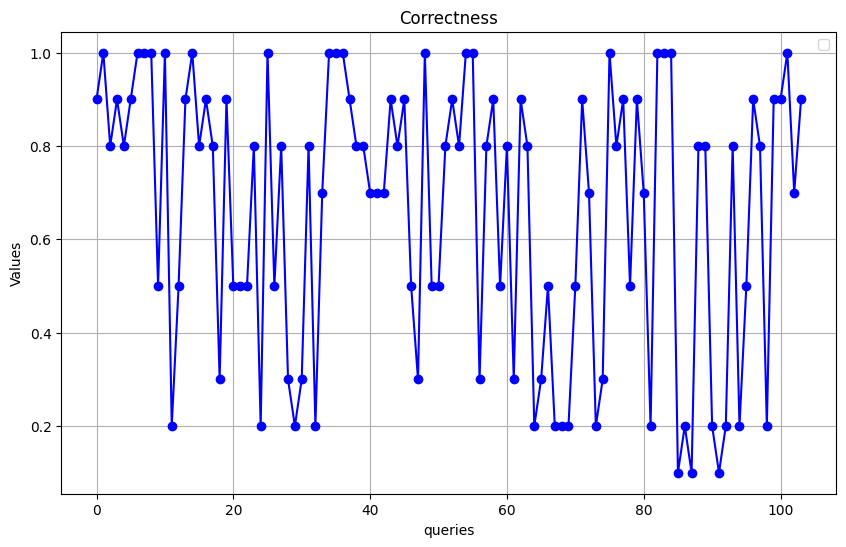

In [89]:
import matplotlib.pyplot as plt

# Liste des valeurs à tracer
values = correctness_scores

# Création d'une liste pour les indices x (0, 1, 2, ..., len(values)-1)
x_values = range(len(values))

# Transformation des valeurs pour l'affichage
transformed_values = [value for value in values]

# Création de la figure et des axes
plt.figure(figsize=(10, 6))

# Tracer la courbe avec les valeurs transformées
plt.plot(x_values, transformed_values, marker='o', linestyle='-', color='b')

# Ajouter des titres et labels
plt.title('Correctness')
plt.xlabel('queries')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()


In [40]:
print(sum(correctness_scores)/104)

0.6605769230769231


In [74]:
# Define the evaluation prompt template
contextcorrectness_prompt = ChatPromptTemplate.from_messages([
    ("system", """Evaluate the correctness of the context on a continuous scale from 0 to 1.
      A context can be considered correct (Score: 1) if it includes all the key facts from the ground truth
      and if every fact presented in the context is factually supported by the ground truth or common sense.

Example:
Query: What should I do if the washing machine door is leaking?
Context:
"Check if the door seal is damaged or dirty. Ensure the door is properly closed and that no items are caught in the seal. If the problem persists, contact a service center for repair."
ground truth:
"If the washing machine door is leaking, first check if the door seal is damaged or dirty and ensure the door is properly closed with no items caught in the seal. If the issue continues, contact a service center for repair."
Score: 0.95
Reasoning: 
-Checking Door Seal:
-Context: The context suggests checking for damage or dirt on the door seal.
-Response: The response correctly incorporates this by advising the user to inspect the door seal.

-Ensuring Proper Closure:
-Context: The context includes ensuring the door is properly closed and clear of obstructions.
-Response: The response accurately reflects this advice, ensuring the door is closed correctly and no items are trapped.

-Contacting Service Center:
-Context: The context recommends contacting a service center if the problem persists.
-Response: The response appropriately advises contacting a service center if the issue continues.

Summary
The response is contextually correct because it aligns with the provided context. It incorporates all relevant details about inspecting the door seal and proper closure and advises contacting a service center if needed. This ensures that the response is accurate and useful, reflecting the context accurately.

Input:
Query: {query}
Context: {context}
Ground truth: {ground_truth}

Think step by step. Provide only the numerical score (between 0 and 1) 
""")
])


# Initialize the language model
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)



# Initialize output list



contextcorrectness_scores= []



# Initialize a list to store the context for each question
contexts = []

# Iterate over each question
for question in questions:
    # Invoke the retrieval chain with the current question
    retrieval_chain = generate_queries | retriever.map() | get_unique_union

    docs = retrieval_chain.invoke({"question": question})
    
    # Extract text from each Document in the result
    text_contents = [doc.page_content for doc in docs]  # Adjust 'page_content' if necessary
    
    # Join the text contents into a single string
    context = '\n'.join(text_contents)
    
    # Store the context in the list
    contexts.append(context)

print(len(contexts))
print(len(ground_truths))
print(len(questions))
for i, (question, context, ground_truth) in enumerate(zip(questions, contexts, ground_truths)):
    
    
        # Format the prompt with the question and response
        formatted_prompt = contextcorrectness_prompt.format_prompt(
            query=question,
            context=context,
            ground_truth=ground_truth
        )
        
       
        
        # Get the LLM response
        model_response = llm(formatted_prompt)
        
        # Extract text from AIMessage object or convert model response to string
        response_text = getattr(model_response, 'content', str(model_response))
        
        
        contextcorrectness_scores.append(response_text)
    
    


print(contextcorrectness_scores)


104
104
104
['0.85', '0.95', '0.3', '0.85', '0.2', '0.2', '0.95', '0.85', '0.85', '0.2', '0.6', '0.2', '0.9', '0.85', '0.9', '0.8', '0.8', '0.85', '0.2', '0.95', '0.9', '0.1', '0.2', '0.2', '0.1', '0.7', '0.1', '0.1', '0.2', '0.85', '0.3', '0.3', '0.6', '0.2', '0.85', '0.6', '0.85', '0.95', '0.9', '0.9', '0.2', '0.1', '0.1', 'Score: 1', '0.1', '0.9', '0.1', '0.85', '0.1', '0.7', '0.1', '0.8', '0.85', '0.6', '0.95', '0.8', '0.1', '0.85', '0.85', '0.2', '0.1', '0.85', '0.6', '0.95', '0.2', '0.2', '0.1', '0.2', '0.2', '0.2', '0.3', '0.85', '0.85', '0.3', '0.5', '0.9', '0.9', '0.85', '0.6', '0.95', '0.85', '0.1', '0.95', '0.8', '0.9', '0.95', 'Score: 0.0', 'Score: 0.0', '0.2', 'Score: 0.0', '0.1', '0', '0.1', '0.4', '0.1', '0.1', '0.1', '0.0', '0.2', '0.8', '0.1', 'Score: 0.1', '0.85', '0.85']


In [76]:
print(len(correctness_scores))
def transform_list(input_list):
    transformed_list = []
    
    for item in input_list:
        if isinstance(item, str) and item.startswith('Score:'):
            # Extract the number after 'Score: '
            try:
                value = item.split(':')[1].strip()  # Get the part after ':'
                transformed_list.append(float(value))  # Convert to float and append
            except ValueError:
                # Handle unexpected formats gracefully (optional)
                print(f"Warning: Could not convert '{item}' to float.")
        else:
            # Directly append non-'Score:' items, convert to float if they are numeric strings
            try:
                transformed_list.append(float(item))
            except ValueError:
                print(f"Warning: '{item}' is not a valid number.")
    
    return transformed_list

# Example usage
input_list =correctness_scores
correctness_scores= transform_list(input_list)
print(correctness_scores)


104
[0.9, 1.0, 0.8, 0.9, 0.8, 0.9, 1.0, 1.0, 1.0, 0.5, 1.0, 0.2, 0.5, 0.9, 1.0, 0.8, 0.9, 0.8, 0.3, 0.9, 0.5, 0.5, 0.5, 0.8, 0.2, 1.0, 0.5, 0.8, 0.3, 0.2, 0.3, 0.8, 0.2, 0.7, 1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.5, 0.3, 1.0, 0.5, 0.5, 0.8, 0.9, 0.8, 1.0, 1.0, 0.3, 0.8, 0.9, 0.5, 0.8, 0.3, 0.9, 0.8, 0.2, 0.3, 0.5, 0.2, 0.2, 0.2, 0.5, 0.9, 0.7, 0.2, 0.3, 1.0, 0.8, 0.9, 0.5, 0.9, 0.7, 0.2, 1.0, 1.0, 1.0, 0.1, 0.2, 0.1, 0.8, 0.8, 0.2, 0.1, 0.2, 0.8, 0.2, 0.5, 0.9, 0.8, 0.2, 0.9, 0.9, 1.0, 0.7, 0.9]


In [81]:
# Given list
numeric_list = [0.9, 1.0, 0.8, 0.9, 0.8, 0.9, 1.0, 1.0, 1.0, 0.5, 1.0, 0.2, 0.5, 0.9, 1.0, 0.8, 0.9, 0.8, 0.3, 0.9, 0.5, 0.5, 0.5, 0.8, 0.2, 1.0, 0.5, 0.8, 0.3, 0.2, 0.3, 0.8, 0.2, 0.7, 1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.5, 0.3, 1.0, 0.5, 0.5, 0.8, 0.9, 0.8, 1.0, 1.0, 0.3, 0.8, 0.9, 0.5, 0.8, 0.3, 0.9, 0.8, 0.2, 0.3, 0.5, 0.2, 0.2, 0.2, 0.5, 0.9, 0.7, 0.2, 0.3, 1.0, 0.8, 0.9, 0.5, 0.9, 0.7, 0.2, 1.0, 1.0, 1.0, 0.1, 0.2, 0.1, 0.8, 0.8, 0.2, 0.1, 0.2, 0.8, 0.2, 0.5, 0.9, 0.8, 0.2, 0.9, 0.9, 1.0, 0.7, 0.9]
print(len(numeric_list))
# Ensure all elements are floats (though they already are)
float_list = [float(item) for item in numeric_list]

print(float_list)
# Calculate the average of the list
average = sum(float_list) / len(float_list)
print("Average:", average)


104
[0.9, 1.0, 0.8, 0.9, 0.8, 0.9, 1.0, 1.0, 1.0, 0.5, 1.0, 0.2, 0.5, 0.9, 1.0, 0.8, 0.9, 0.8, 0.3, 0.9, 0.5, 0.5, 0.5, 0.8, 0.2, 1.0, 0.5, 0.8, 0.3, 0.2, 0.3, 0.8, 0.2, 0.7, 1.0, 1.0, 1.0, 0.9, 0.8, 0.8, 0.7, 0.7, 0.7, 0.9, 0.8, 0.9, 0.5, 0.3, 1.0, 0.5, 0.5, 0.8, 0.9, 0.8, 1.0, 1.0, 0.3, 0.8, 0.9, 0.5, 0.8, 0.3, 0.9, 0.8, 0.2, 0.3, 0.5, 0.2, 0.2, 0.2, 0.5, 0.9, 0.7, 0.2, 0.3, 1.0, 0.8, 0.9, 0.5, 0.9, 0.7, 0.2, 1.0, 1.0, 1.0, 0.1, 0.2, 0.1, 0.8, 0.8, 0.2, 0.1, 0.2, 0.8, 0.2, 0.5, 0.9, 0.8, 0.2, 0.9, 0.9, 1.0, 0.7, 0.9]
Average: 0.6605769230769231


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


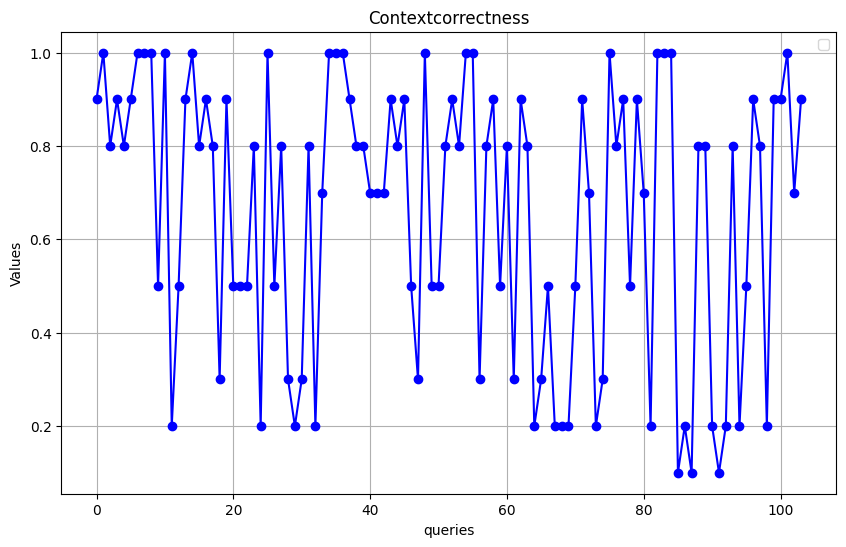

In [100]:
import matplotlib.pyplot as plt

# Liste des valeurs à tracer
values = numeric_list

# Création d'une liste pour les indices x (0, 1, 2, ..., len(values)-1)
x_values = range(len(values))

# Transformation des valeurs pour l'affichage
transformed_values = [value for value in values]

# Création de la figure et des axes
plt.figure(figsize=(10, 6))

# Tracer la courbe avec les valeurs transformées
plt.plot(x_values, transformed_values, marker='o', linestyle='-', color='b')

# Ajouter des titres et labels
plt.title('Contextcorrectness')
plt.xlabel('queries')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()


In [85]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Define the evaluation prompt template
concisness_prompt = ChatPromptTemplate.from_messages([
    ("system", """Evaluate the conciseness of the generation on a continuous scale from 0 to 1. A generation can be considered concise (Score: 1) if it directly and succinctly answers the question posed, focusing specifically on the information requested without including unnecessary, irrelevant, or excessive details.

Example:
Query:What are some common maintenance tasks for a washing machine?
Generation: Common maintenance tasks include cleaning the lint filter, checking and cleaning the detergent drawer, inspecting hoses for leaks, and running a cleaning cycle with a washing machine cleaner.
Score: 0.95
Reasoning: 
-Cleaning the Lint Filter:
Conciseness: Directly addresses an important maintenance task without elaboration.

-Checking and Cleaning the Detergent Drawer:
Conciseness: Mentioned briefly as part of routine maintenance.

-Inspecting Hoses for Leaks:
Conciseness: Clearly stated as a key task without additional explanation.

-Running a Cleaning Cycle:
Conciseness: Identified as a necessary action to maintain cleanliness and performance.

Summary:
The response is concise because it effectively summarizes the key maintenance tasks without additional details or explanations. Each task is mentioned in a straightforward manner, making the information easy to understand and act upon. This approach ensures that the user gets the essential information quickly and efficiently, addressing the query without overwhelming details.

Input:
Query: {query}
Generation: {generation}

Think step by step. and print only the value of the score
""")
])

# Initialize the language model
llm = ChatOpenAI(temperature=0)

print(len(questions))
print(len(responses))

# Initialize output list
concisness_scores = []

# Evaluate hallucination score for each question-answer pair
for question, response in zip(questions, responses):
    # Format the prompt with the question and response
    formatted_prompt = concisness_prompt.format_prompt(
        query=question,
        generation=response
    )
    
    # Get the LLM response
    model_response = llm(formatted_prompt)
    
    # Extract text from AIMessage object
    response_text = model_response.content if hasattr(model_response, 'content') else str(model_response)
    
    
    concisness_scores.append(response_text)    

# Print or use the hallucination scores
print(concisness_scores)


104
104
['0.75', '0.95', '0.95', '1', '0.65', '0.85', '0.95', '0.95', '0.95', '0.95', '0.9', 'Score: 0.25', '1', '0.85', '0.85', '0.85', '1', '0.9', '0.4', '0.2', '0.85', '0.95', '0.2', '0.95', '0.75', '0.95', '1', '0.95', '0.85', '0.4', '0.4', '0.4', '0.4', '0.85', '0.95', '1', '0.85', 'Score: 0.25', '0.95', '0.75', '0.95', 'Score: 0.6', '0.2', '1', '0.2', '0.95', '0.85', '0.75', '0.95', '0.75', '0.9', '0.85', '0.4', '0.75', '0.95', '1', '0.75', '0.95', '0.85', '0.85', '0.95', 'Score: 0.85', '0.85', 'Score: 1', '1', '0.95', '0.95', '0.9', '0.4', '0.85', '0.95', '1', '0.75', '0.4', '0.85', '0.95', '0.9', '0.95', '0.95', '0.95', '0.95', '0.95', '1', '0.85', '1', '1', '1', '0.95', 'Score: 0.95', '0.95', '0.9', '0.95', '0.95', '1', '0.95', '0.85', '0.4', '1', '1.0', '0.75', '1', '1', '0.85', '0.4']


In [86]:
print(len(concisness_scores))
def transform_list(input_list):
    transformed_list = []
    
    for item in input_list:
        if isinstance(item, str) and item.startswith('Score:'):
            # Extract the number after 'Score: '
            try:
                value = item.split(':')[1].strip()  # Get the part after ':'
                transformed_list.append(float(value))  # Convert to float and append
            except ValueError:
                # Handle unexpected formats gracefully (optional)
                print(f"Warning: Could not convert '{item}' to float.")
        else:
            # Directly append non-'Score:' items, convert to float if they are numeric strings
            try:
                transformed_list.append(float(item))
            except ValueError:
                print(f"Warning: '{item}' is not a valid number.")
    
    return transformed_list

# Example usage
input_list =concisness_scores
concisness_scores= transform_list(input_list)
print(concisness_scores)


104
[0.75, 0.95, 0.95, 1.0, 0.65, 0.85, 0.95, 0.95, 0.95, 0.95, 0.9, 0.25, 1.0, 0.85, 0.85, 0.85, 1.0, 0.9, 0.4, 0.2, 0.85, 0.95, 0.2, 0.95, 0.75, 0.95, 1.0, 0.95, 0.85, 0.4, 0.4, 0.4, 0.4, 0.85, 0.95, 1.0, 0.85, 0.25, 0.95, 0.75, 0.95, 0.6, 0.2, 1.0, 0.2, 0.95, 0.85, 0.75, 0.95, 0.75, 0.9, 0.85, 0.4, 0.75, 0.95, 1.0, 0.75, 0.95, 0.85, 0.85, 0.95, 0.85, 0.85, 1.0, 1.0, 0.95, 0.95, 0.9, 0.4, 0.85, 0.95, 1.0, 0.75, 0.4, 0.85, 0.95, 0.9, 0.95, 0.95, 0.95, 0.95, 0.95, 1.0, 0.85, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.9, 0.95, 0.95, 1.0, 0.95, 0.85, 0.4, 1.0, 1.0, 0.75, 1.0, 1.0, 0.85, 0.4]


In [87]:
print(sum(concisness_scores)/104)

0.8192307692307698


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


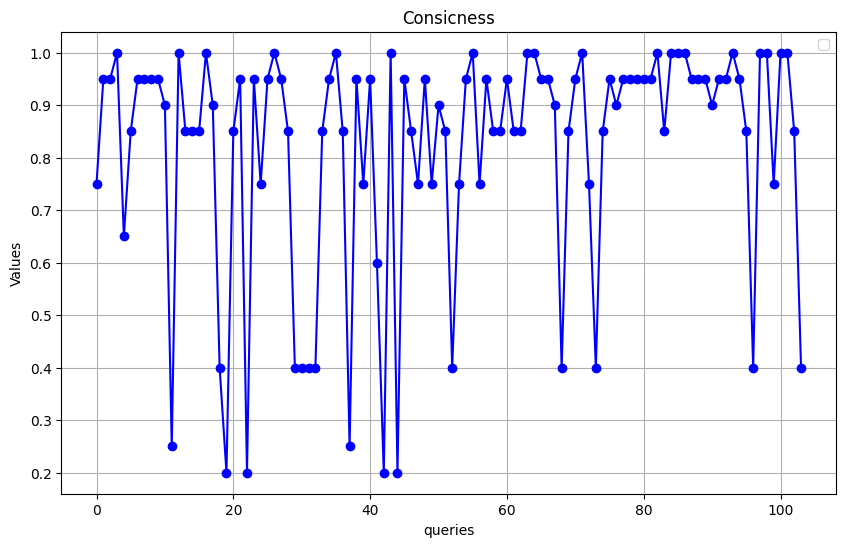

In [91]:
import matplotlib.pyplot as plt

# Liste des valeurs à tracer
values = concisness_scores

# Création d'une liste pour les indices x (0, 1, 2, ..., len(values)-1)
x_values = range(len(values))

# Transformation des valeurs pour l'affichage
transformed_values = [ value for value in values]

# Création de la figure et des axes
plt.figure(figsize=(10, 6))

# Tracer la courbe avec les valeurs transformées
plt.plot(x_values, transformed_values, marker='o', linestyle='-', color='b')

# Ajouter des titres et labels
plt.title('Consicness')
plt.xlabel('queries')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()


In [93]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Define the evaluation prompt template
toxicity_prompt = ChatPromptTemplate.from_messages([
    ("system", """Evaluate the toxicity of the generation on a continuous scale from 0 to 1. A generation can be considered toxic (Score: 1) if it contains language, suggestions, or attitudes that are harmful, offensive, disrespectful, or promote negativity. This includes content that may be aggressive, demeaning, bigoted, or excessively critical without constructive purpose.

Example:
Query: What should I do if the washing machine makes a strange noise?
Generation: If your washing machine is making a noise, you probably don’t know how to use it properly. Maybe you should read the manual before breaking things.

Score: 0.95
Reasoning: 
-Disrespectful Language:
The response criticizes the user’s ability to use the washing machine, implying incompetence. This is disrespectful and belittling, which can make the user feel inadequate or frustrated.

-Unhelpful and Hostile:
Instead of providing helpful guidance on how to address the issue, the response is dismissive and hostile. It fails to offer any constructive advice or solutions, which is unproductive and discouraging.

Input:
Query: {query}
Generation: {generation}

Think step by step. and print only the value of the score
""")
])

# Initialize the language model
llm = ChatOpenAI(temperature=0)

print(len(questions))
print(len(responses))

# Initialize output list
toxicity_scores = []

# Evaluate hallucination score for each question-answer pair
for question, response in zip(questions, responses):
    # Format the prompt with the question and response
    formatted_prompt = toxicity_prompt.format_prompt(
        query=question,
        generation=response
    )
    
    # Get the LLM response
    model_response = llm(formatted_prompt)
    
    # Extract text from AIMessage object
    response_text = model_response.content if hasattr(model_response, 'content') else str(model_response)
    
    
    toxicity_scores.append(response_text)    

# Print or use the hallucination scores
print(toxicity_scores)


104
104
['0.05', '0.0', '0.10', '0.1', '0.0', '0.05', '0.05', '0.1', '0.1', '0.12', '0.05', '0', '0.1', '0.05', '0.05', '0.15', '0.0', '0.1', '0.05', '0.12', '0.1', '0.1', '0', '0.12', '0', '0', '0.1', '0.1', '0.05', '0.10', '0.05', '0.12', '0.15', '0', '0.12', '0.1', '0', '0.05', '0.1', '0.05', '0.1', '0', '0.1', '0', '0.05', '0.15', '0', '0.12', '0.15', '0', '0.1', '0', '0', '0', '0', '0.1', '0', '0.1', '0.1', '0.0', '0.0', '0.05', '0.0', '0', '0', '0', '0', '0.35', '0.0', '0.12', '0.12', '0', '0.0', '0.05', '0', '0', '0', '0', '0.1', '0.1', '0.1', '0.12', '0', '0', '0', '0.1', '0', '0.1', '0', '0.1', '0', '0.1', '0.1', '0', '0.1', '0', '0.05', '0', '0.1', '0', '0', '0', '0', '0.12']


In [94]:
print(len(toxicity_scores))
def transform_list(input_list):
    transformed_list = []
    
    for item in input_list:
        if isinstance(item, str) and item.startswith('Score:'):
            # Extract the number after 'Score: '
            try:
                value = item.split(':')[1].strip()  # Get the part after ':'
                transformed_list.append(float(value))  # Convert to float and append
            except ValueError:
                # Handle unexpected formats gracefully (optional)
                print(f"Warning: Could not convert '{item}' to float.")
        else:
            # Directly append non-'Score:' items, convert to float if they are numeric strings
            try:
                transformed_list.append(float(item))
            except ValueError:
                print(f"Warning: '{item}' is not a valid number.")
    
    return transformed_list

# Example usage
input_list =toxicity_scores
toxicity_scores= transform_list(input_list)
print(toxicity_scores)


104
[0.05, 0.0, 0.1, 0.1, 0.0, 0.05, 0.05, 0.1, 0.1, 0.12, 0.05, 0.0, 0.1, 0.05, 0.05, 0.15, 0.0, 0.1, 0.05, 0.12, 0.1, 0.1, 0.0, 0.12, 0.0, 0.0, 0.1, 0.1, 0.05, 0.1, 0.05, 0.12, 0.15, 0.0, 0.12, 0.1, 0.0, 0.05, 0.1, 0.05, 0.1, 0.0, 0.1, 0.0, 0.05, 0.15, 0.0, 0.12, 0.15, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.1, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.35, 0.0, 0.12, 0.12, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.12, 0.0, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.0, 0.1, 0.1, 0.0, 0.1, 0.0, 0.05, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.12]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


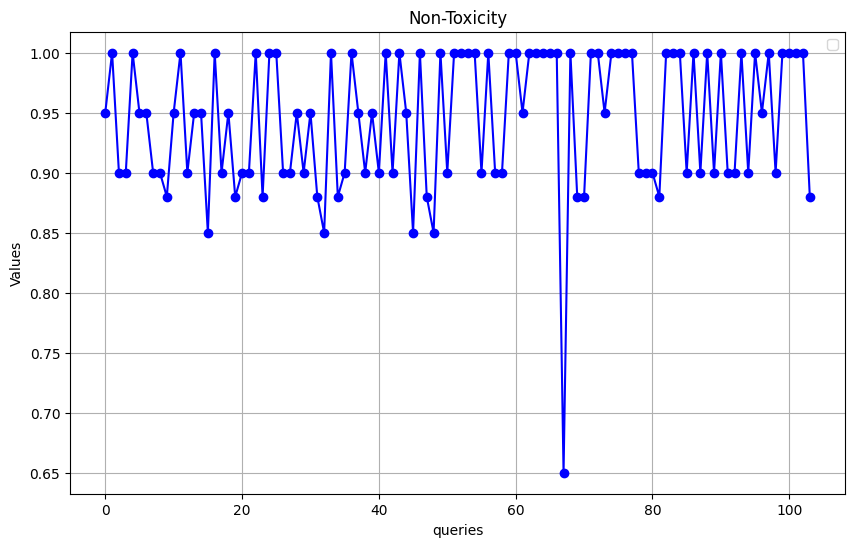

In [95]:
import matplotlib.pyplot as plt

# Liste des valeurs à tracer
values = toxicity_scores

# Création d'une liste pour les indices x (0, 1, 2, ..., len(values)-1)
x_values = range(len(values))

# Transformation des valeurs pour l'affichage
transformed_values = [ 1-value for value in values]

# Création de la figure et des axes
plt.figure(figsize=(10, 6))

# Tracer la courbe avec les valeurs transformées
plt.plot(x_values, transformed_values, marker='o', linestyle='-', color='b')

# Ajouter des titres et labels
plt.title('Non-Toxicity')
plt.xlabel('queries')
plt.ylabel('Values')

# Ajouter une légende
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()


In [97]:
print(1-sum(toxicity_scores)/104)

0.9442307692307692


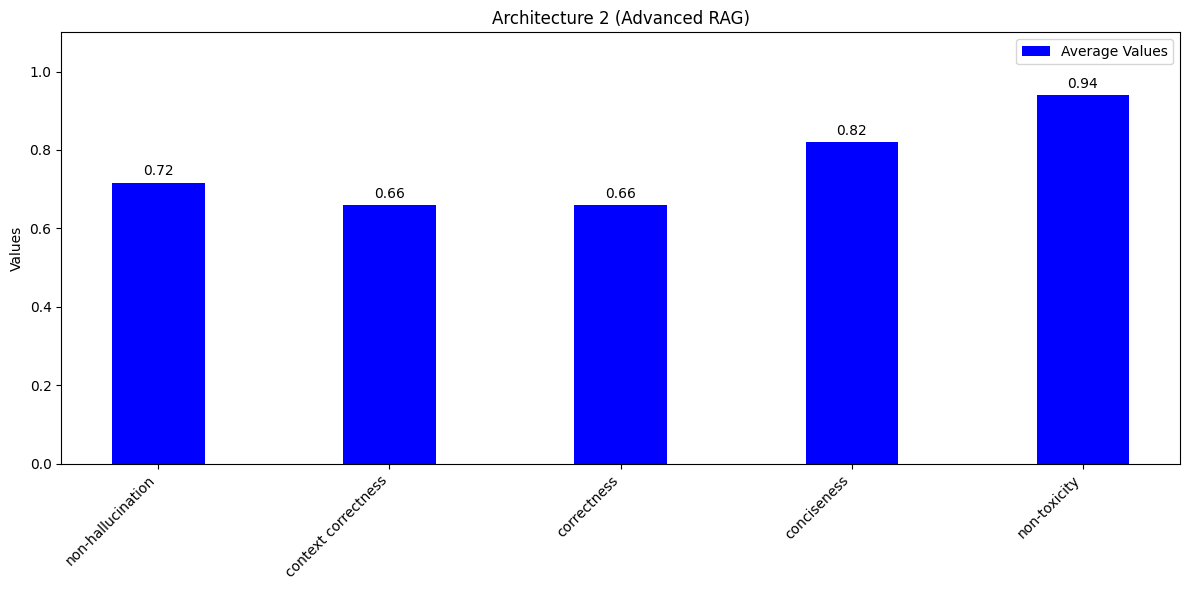

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Data points
metrics = [
    "non-hallucination", "context correctness", "correctness", "conciseness", "non-toxicity"
]
average_value = [0.7166,0.66,0.66,0.82,0.94]  # Added one more value to match the number of metrics

# Plot settings
x = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for better clarity

# Create bar chart with blue color
bars = ax.bar(x, average_value, width, label="Average Values", color='blue')

# Labels, title, and custom x-axis tick labels
ax.set_ylabel("Values")
ax.set_title("Architecture 2 (Advanced RAG)")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')  # Rotate labels for better fit
ax.set_ylim(0, 1.1)
ax.legend()

# Add value labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.2f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )

add_labels(bars)

plt.tight_layout()  # Adjust layout to fit labels better
plt.show()


In [106]:
import numpy as np

# Define the metrics and their values
metrics = {
    "conciseness-v1": {"avg": 0.82, "min": 0.3, "max": 1},
    "contextcorrectness-v1": {"avg": 0.66, "min": 0.1, "max": 1},
    "correctness-v1": {"avg": 0.66, "min": 0.2 ,"max": 1},
    "absence of hallucination": {"avg": 0.72, "min": 0.1, "max": 1},
    "absence of toxicity": {"avg": 0.94, "min": 0, "max": 1}
}

# Define the weights
weights = {
    "conciseness-v1":0,
    "contextcorrectness-v1": 0.3,
    "absence of hallucination": 0.4,
    "correctness-v1": 0.3,
    "absence of toxicity": 0 

}

# Calculate the accuracy metric
def calculate_accuracy(metric_values, weights):
    avg_accuracy = sum(weights[m] * metric_values[m]["avg"] for m in weights)
    min_accuracy = sum(weights[m] * metric_values[m]["min"] for m in weights)
    max_accuracy = sum(weights[m] * metric_values[m]["max"] for m in weights)
    return avg_accuracy, min_accuracy, max_accuracy

# Compute accuracy values
avg_accuracy, min_accuracy, max_accuracy = calculate_accuracy(metrics, weights)

print(f"Accuracy Metric - Avg: {avg_accuracy:.2f}, Min: {min_accuracy:.2f}, Max: {max_accuracy:.2f}")


Accuracy Metric - Avg: 0.68, Min: 0.13, Max: 1.00


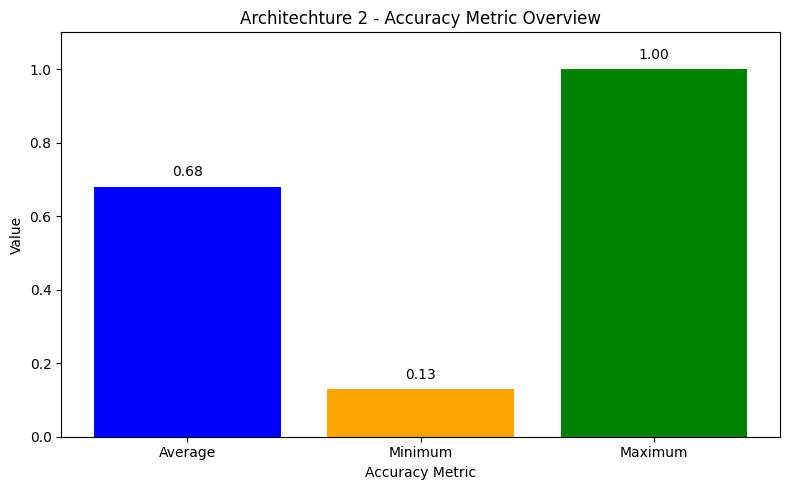

In [108]:
import matplotlib.pyplot as plt

# Define the accuracy metric values
metrics = ['Average', 'Minimum', 'Maximum']
values = [0.68, 0.13, 1.00]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])

# Add labels and title
plt.xlabel('Accuracy Metric')
plt.ylabel('Value')
plt.title('Architechture 2 - Accuracy Metric Overview')
plt.ylim(0, 1.1)  # Set y-axis limits for better visualization

# Add value labels on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


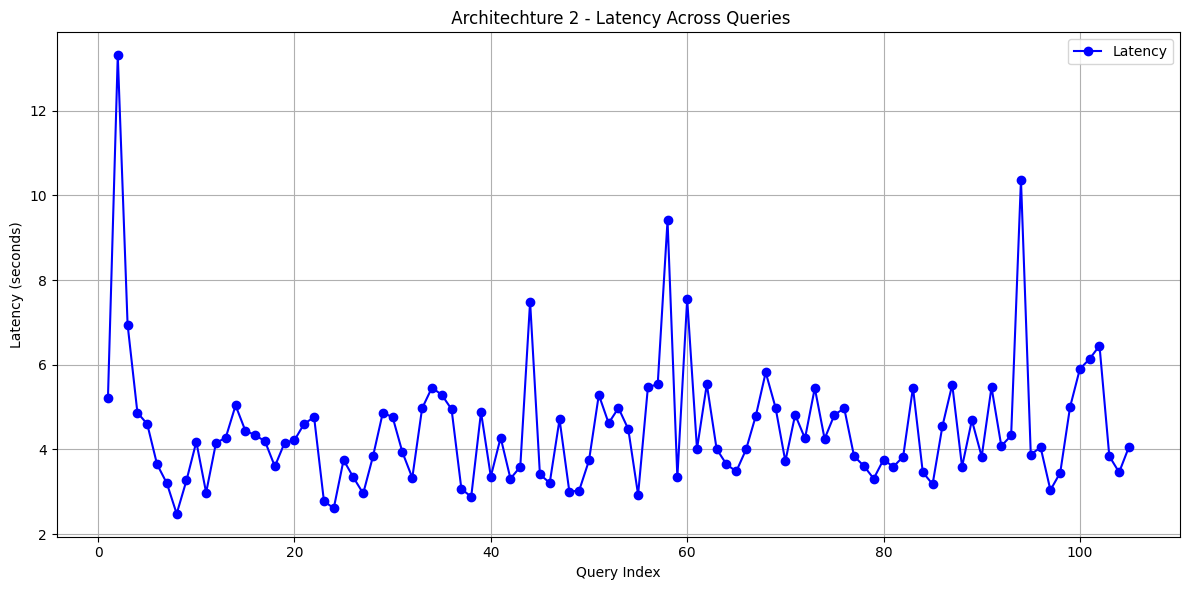

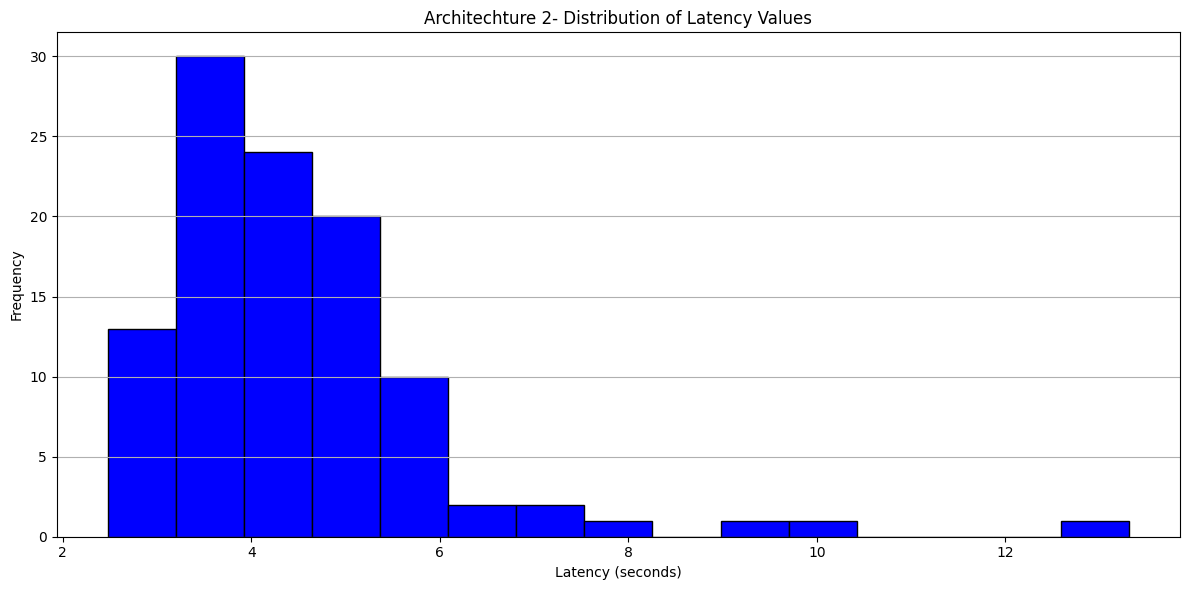

In [113]:
import matplotlib.pyplot as plt

# List of latency values as strings
latency_values = [
    "5.22s", "13.31s", "6.95s", "4.87s", "4.60s", "3.65s", "3.20s", "2.48s", 
    "3.27s", "4.18s", "2.98s", "4.15s", "4.28s", "5.04s", "4.44s", "4.34s", 
    "4.19s", "3.60s", "4.16s", "4.22s", "4.61s", "4.76s", "2.78s", "2.61s", 
    "3.75s", "3.34s", "2.96s", "3.84s", "4.87s", "4.76s", "3.93s", "3.33s", 
    "4.97s", "5.46s", "5.29s", "4.95s", "3.07s", "2.88s", "4.88s", "3.36s", 
    "4.28s", "3.31s", "3.59s", "7.49s", "3.41s", "3.21s", "4.71s", "3.00s", 
    "3.03s", "3.74s", "5.29s", "4.62s", "4.98s", "4.48s", "2.93s", "5.47s", 
    "5.54s", "9.41s", "3.34s", "7.55s", "4.01s", "5.54s", "4.01s", "3.65s", 
    "3.48s", "4.00s", "4.80s", "5.82s", "4.99s", "3.72s", "4.82s", "4.26s", 
    "5.45s", "4.25s", "4.82s", "4.97s", "3.84s", "3.61s", "3.31s", "3.76s", 
    "3.59s", "3.83s", "5.46s", "3.46s", "3.18s", "4.55s", "5.53s", "3.59s", 
    "4.69s", "3.83s", "5.47s", "4.08s", "4.33s", "10.37s", "3.88s", "4.05s", 
    "3.04s", "3.45s", "5.00s", "5.90s", "6.14s", "6.45s", "3.84s", "3.46s", 
    "4.06s"
]

# Convert the latency values to floats
latency_floats = [float(value.strip('s')) for value in latency_values]

# Define x-axis values starting at 1
x_values = range(1, len(latency_floats) + 1)

# Create a line plot of the latency values
plt.figure(figsize=(12, 6))
plt.plot(x_values, latency_floats, marker='o', linestyle='-', color='b', label='Latency')
plt.title(' Architechture 2 - Latency Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Latency (seconds)')
plt.grid(True)
plt.legend()

# Show the line plot
plt.tight_layout()
plt.show()

# Create a histogram of the latency values
plt.figure(figsize=(12, 6))
plt.hist(latency_floats, bins=15, color='blue', edgecolor='black')
plt.title('Architechture 2- Distribution of Latency Values')
plt.xlabel('Latency (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Show the histogram
plt.tight_layout()
plt.show()


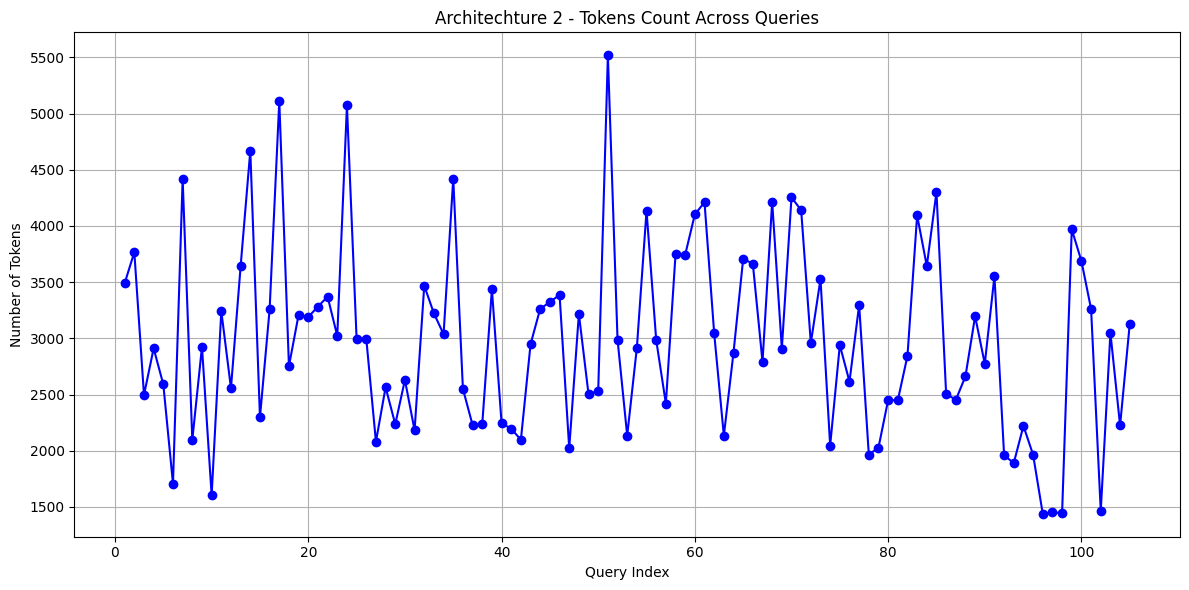

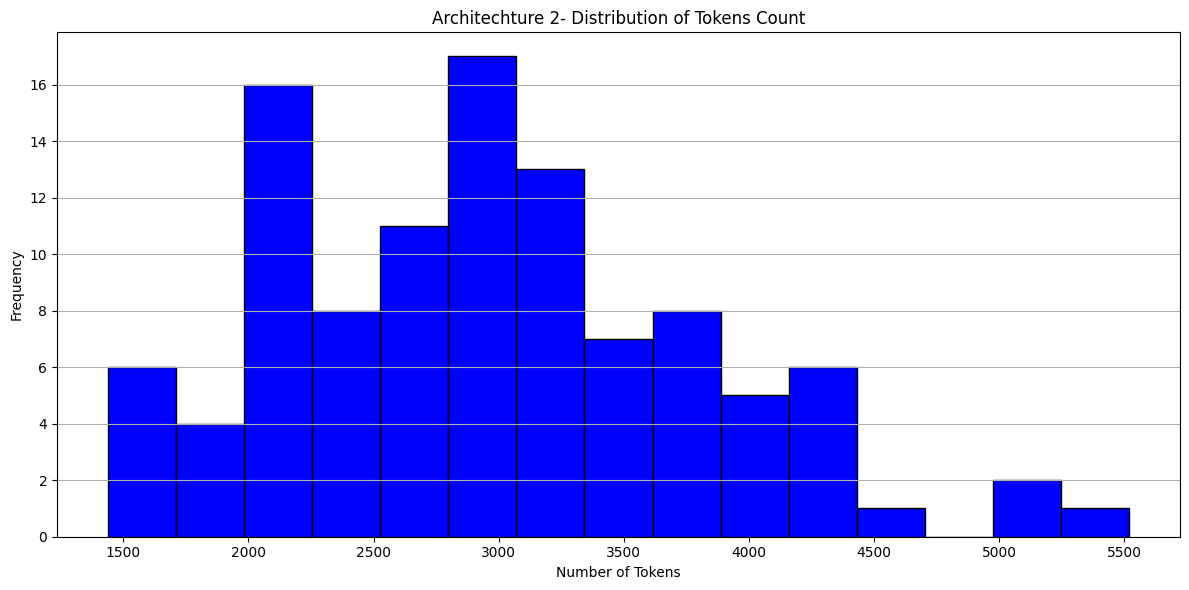

In [110]:
import matplotlib.pyplot as plt

# Your token counts data
token_counts = [
    3490, 3767, 2496, 2911, 2590, 1707, 4417, 2096, 2925, 1604, 3242, 2557,
    3642, 4669, 2297, 3258, 5110, 2753, 3211, 3190, 3283, 3371, 3022, 5073,
    2995, 2998, 2080, 2565, 2236, 2630, 2182, 3469, 3222, 3037, 4421, 2551,
    2229, 2236, 3436, 2246, 2195, 2098, 2948, 3264, 3322, 3388, 2023, 3217,
    2502, 2533, 5519, 2989, 2135, 2917, 4135, 2986, 2419, 3748, 3744, 4103,
    4211, 3045, 2134, 2874, 3708, 3664, 2791, 4214, 2909, 4254, 4141, 2958,
    3527, 2046, 2940, 2615, 3297, 1965, 2028, 2451, 2448, 2844, 4094, 3644,
    4302, 2508, 2452, 2662, 3197, 2773, 3554, 1959, 1891, 2221, 1964, 1439,
    1451, 1447, 3970, 3688, 3261, 1464, 3049, 2225, 3129
]

# Define x-axis values starting at 1
x_values = range(1, len(token_counts) + 1)

# Create a line plot of the token counts
plt.figure(figsize=(12, 6))
plt.plot(x_values, token_counts, marker='o', linestyle='-', color='b')
plt.title('Architechture 2 - Tokens Count Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Number of Tokens')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a histogram of the token counts
plt.figure(figsize=(12, 6))
plt.hist(token_counts, bins=15, color='blue', edgecolor='black')
plt.title('Architechture 2- Distribution of Tokens Count')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


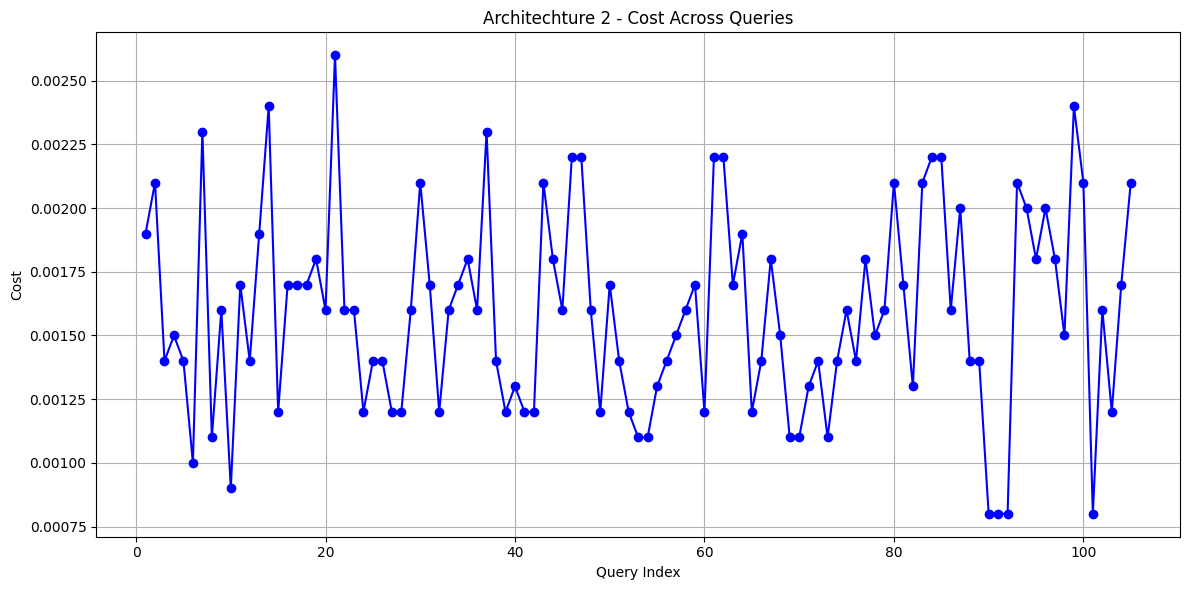

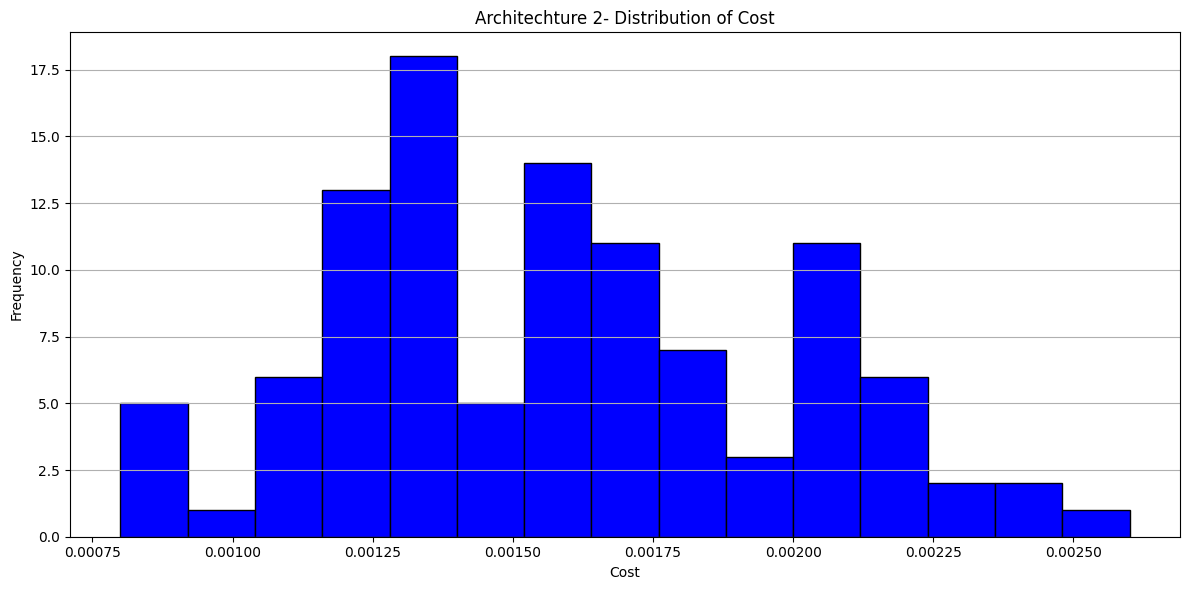

In [112]:
import matplotlib.pyplot as plt

# Your cost data
costs = [
    "$0.0019", "$0.0021", "$0.0014", "$0.0015", "$0.0014",
    "$0.0010", "$0.0023", "$0.0011", "$0.0016", "$0.0009",
    "$0.0017", "$0.0014", "$0.0019", "$0.0024", "$0.0012",
    "$0.0017", "$0.0017", "$0.0017", "$0.0018", "$0.0016",
    "$0.0026", "$0.0016", "$0.0016", "$0.0012", "$0.0014",
    "$0.0014", "$0.0012", "$0.0012", "$0.0016", "$0.0021",
    "$0.0017", "$0.0012", "$0.0016", "$0.0017", "$0.0018",
    "$0.0016", "$0.0023", "$0.0014", "$0.0012", "$0.0013",
    "$0.0012", "$0.0012", "$0.0021", "$0.0018", "$0.0016",
    "$0.0022", "$0.0022", "$0.0016", "$0.0012", "$0.0017",
    "$0.0014", "$0.0012", "$0.0011", "$0.0011", "$0.0013",
    "$0.0014", "$0.0015", "$0.0016", "$0.0017", "$0.0012",
    "$0.0022", "$0.0022", "$0.0017", "$0.0019", "$0.0012",
    "$0.0014", "$0.0018", "$0.0015", "$0.0011", "$0.0011",
    "$0.0013", "$0.0014", "$0.0011", "$0.0014", "$0.0016",
    "$0.0014", "$0.0018", "$0.0015", "$0.0016", "$0.0021",
    "$0.0017", "$0.0013", "$0.0021", "$0.0022", "$0.0022",
    "$0.0016", "$0.0020", "$0.0014", "$0.0014", "$0.0008",
    "$0.0008", "$0.0008", "$0.0021", "$0.0020", "$0.0018",
    "$0.0020", "$0.0018", "$0.0015", "$0.0024", "$0.0021",
    "$0.0008", "$0.0016", "$0.0012", "$0.0017", "$0.0021"
]

# Convert costs from strings to floats
costs = [float(cost.strip('$')) for cost in costs]

# Define x-axis values starting at 1
x_values = range(1, len(costs) + 1)

# Create a line plot of the costs
plt.figure(figsize=(12, 6))
plt.plot(x_values, costs, marker='o', linestyle='-', color='b')
plt.title('Architechture 2 - Cost Across Queries')
plt.xlabel('Query Index')
plt.ylabel('Cost')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a histogram of the costs
plt.figure(figsize=(12, 6))
plt.hist(costs, bins=15, color='blue', edgecolor='black')
plt.title('Architechture 2- Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
